<a href="https://colab.research.google.com/github/canmizrakli/TDSP.Net/blob/main/TDSP_YOLO_mini_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TDSP (Task-Driven Saliency Prediction) with a Small Subset per Task

In this notebook, we will:
1. Mount Google Drive and install the necessary dependencies.
2. Define paired data augmentations.
3. Build a custom dataset class with a `max_samples_per_task` parameter (to load only a small subset per task).
4. Define a YOLO-based saliency model with a custom saliency loss.
5. Train on a small subset (e.g., 50 samples per task) to perform a quick “sanity check” and confirm the model can learn on a reduced dataset.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade torch torchvision einops ultralytics sentence-transformers

Data Augmentation & Paired Transforms

In [3]:
import random
import torchvision.transforms.functional as TF  # Use TF to avoid conflicts with torch.nn.functional

# Paired random horizontal flip
class PairedRandomHorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, sal):
        if random.random() < self.p:
            img = TF.hflip(img)
            sal = TF.hflip(sal)
        return img, sal

# Paired random rotation
class PairedRandomRotation:
    def __init__(self, degrees=10):
        self.degrees = degrees

    def __call__(self, img, sal):
        angle = random.uniform(-self.degrees, self.degrees)
        img = TF.rotate(img, angle)
        sal = TF.rotate(sal, angle)
        return img, sal


Dataset Definition (with max_samples_per_task)

In [4]:
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import random

# Define task mapping from folder names to descriptive labels.
task_mapping = {
    "task1": "free view",
    "task2": "count people",
    "task3": "detect the emotion",
    "task4": "identify the action"
}

class TaskSaliencyDataset(Dataset):
    def __init__(self, data_root, task_mapping, transform=None, saliency_transform=None,
                 paired_transforms=None, max_samples_per_task=None):
        """
        data_root: Root path of the dataset.
        task_mapping: Dict mapping folder names (e.g. "task1") to descriptive labels.
        transform: Transforms for stimuli images.
        saliency_transform: Transforms for saliency maps.
        paired_transforms: List of callables applying same random transform to both stimuli & saliency.
        max_samples_per_task: If set (e.g., 50), load up to 50 samples per task only (sanity check).
        """
        self.data_root = data_root
        self.task_mapping = task_mapping
        self.transform = transform
        self.saliency_transform = saliency_transform
        self.paired_transforms = paired_transforms
        self.max_samples_per_task = max_samples_per_task

        self.tasks = list(task_mapping.keys())
        self.samples = []

        for task in self.tasks:
            task_folder = os.path.join(data_root, task)
            fdm_folder = os.path.join(task_folder, "fdm")
            fdm_files = glob.glob(os.path.join(fdm_folder, "*.png"))

            # If you want random subsets, you can shuffle here:
            # random.shuffle(fdm_files)

            count = 0
            for fdm_file in fdm_files:
                if self.max_samples_per_task is not None and count >= self.max_samples_per_task:
                    break
                filename = os.path.basename(fdm_file)
                base = os.path.splitext(filename)[0]

                stimuli_path_jpg = os.path.join(data_root, "stimuli", base + ".jpg")
                stimuli_path_png = os.path.join(data_root, "stimuli", base + ".png")

                if os.path.exists(stimuli_path_jpg):
                    stimuli_path = stimuli_path_jpg
                elif os.path.exists(stimuli_path_png):
                    stimuli_path = stimuli_path_png
                else:
                    continue

                self.samples.append((stimuli_path, fdm_file, task))
                count += 1

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        stimuli_path, fdm_path, task = self.samples[idx]
        stimuli_img = Image.open(stimuli_path).convert("RGB")
        fdm_img = Image.open(fdm_path).convert("L")

        if self.transform:
            stimuli_img = self.transform(stimuli_img)
        if self.saliency_transform:
            fdm_img = self.saliency_transform(fdm_img)
        else:
            fdm_img = T.ToTensor()(fdm_img)

        if self.paired_transforms is not None:
            for t in self.paired_transforms:
                stimuli_img, fdm_img = t(stimuli_img, fdm_img)

        task_description = self.task_mapping[task]

        return {
            "stimuli": stimuli_img,
            "fdm": fdm_img,
            "task": task,
            "task_description": task_description
        }

# Example transforms
input_transform = T.Compose([
    T.Resize((384, 384)),
    T.ToTensor(),
])
saliency_transform = T.Compose([
    T.Resize((384, 384)),
    T.ToTensor(),
])
paired_transforms = [
    PairedRandomHorizontalFlip(p=0.5),
    PairedRandomRotation(degrees=10)
]

DATA_PATH = "/content/drive/MyDrive/TDSP/Task-based-eye-fixation-dataset_1024x768"

# Here, we set max_samples_per_task=50 to load only 50 images per task
dataset = TaskSaliencyDataset(
    data_root=DATA_PATH,
    task_mapping=task_mapping,
    transform=input_transform,
    saliency_transform=saliency_transform,
    paired_transforms=paired_transforms,
    max_samples_per_task=50
)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)

print("Tasks found:", dataset.tasks)
print("Number of samples loaded:", len(dataset))


Tasks found: ['task1', 'task2', 'task3', 'task4']
Number of samples loaded: 200


Model Components

In [5]:
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from ultralytics import YOLO
from sentence_transformers import SentenceTransformer

# 6.1 Pre-trained YOLO Backbone
class YOLOBackbone(nn.Module):
    def __init__(self, model_name="yolov5s.pt"):
        super().__init__()
        # Load pre-trained YOLO model by specifying the weight file
        self.yolo_model = YOLO(model_name)
        # Retain only the feature extraction layers (adjust slicing if needed)
        self.feature_extractor = self.yolo_model.model.model[:10]

    def forward(self, x):
        return self.feature_extractor(x)

    def train(self, mode=True):
        # Only set training mode on the feature extractor
        self.feature_extractor.train(mode)
        return self

# 6.2 Simple FPN
class SimpleFPN(nn.Module):
    def __init__(self, in_channels=512, out_channels=128):
        super().__init__()
        self.conv_out = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, backbone_feats):
        x = self.conv_out(backbone_feats)
        return x

# 6.3 Task Encoder
class TaskEncoder(nn.Module):
    def __init__(self, output_dim=64):
        super().__init__()
        self.text_encoder = SentenceTransformer('all-MiniLM-L6-v2')
        self.linear = nn.Linear(384, output_dim)  # reduce 384 -> 64

    def forward(self, task_descriptions):
        embeddings = self.text_encoder.encode(task_descriptions, convert_to_tensor=True)
        embeddings = self.linear(embeddings)
        return F.relu(embeddings)

# 6.4 Transformer Fusion
class TransformerFusion(nn.Module):
    def __init__(self, d_model=128, nhead=4, num_layers=1, task_embed_dim=64):
        super().__init__()
        self.query_proj = nn.Linear(task_embed_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, vision_feats, task_embed):
        B, C, H, W = vision_feats.shape
        vision_seq = rearrange(vision_feats, 'b c h w -> (h w) b c')
        task_query = self.query_proj(task_embed)
        task_query = rearrange(task_query, 'b d -> 1 b d')
        fused_seq = torch.cat([task_query, vision_seq], dim=0)
        encoded_seq = self.transformer_encoder(fused_seq)
        encoded_vision = encoded_seq[1:, :, :]
        encoded_vision = rearrange(encoded_vision, '(h w) b c -> b c h w', h=H, w=W)
        return encoded_vision

# 6.5 Saliency Decoder
class SaliencyDecoder(nn.Module):
    def __init__(self, in_channels=128):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.conv2(x)
        return torch.sigmoid(x)

# 6.6 Complete YOLOTaskSaliencyModel
class YOLOTaskSaliencyModel(nn.Module):
    def __init__(self, task_embed_dim=64, vision_dim=128, nhead=4, num_layers=1):
        super().__init__()
        self.backbone = YOLOBackbone(model_name="yolov5s.pt")
        self.fpn = SimpleFPN(in_channels=512, out_channels=128)
        self.task_encoder = TaskEncoder(output_dim=task_embed_dim)
        self.transformer_fusion = TransformerFusion(
            d_model=vision_dim, nhead=nhead,
            num_layers=num_layers, task_embed_dim=task_embed_dim
        )
        self.saliency_decoder = SaliencyDecoder(in_channels=vision_dim)

    def forward(self, images, task_descs):
        feat = self.backbone(images)          # [B, 512, H/?, W/?]
        feat = self.fpn(feat)                 # [B, 128, H/?, W/?]
        task_embed = self.task_encoder(task_descs)  # [B, 64]
        fused_feat = self.transformer_fusion(feat, task_embed)  # [B, 128, H/?, W/?]
        saliency_map = self.saliency_decoder(fused_feat)        # [B, 1, H/?, W/?]
        # Upsample to input size
        saliency_map_upsampled = F.interpolate(
            saliency_map,
            size=(images.shape[2], images.shape[3]),
            mode='bilinear',
            align_corners=False
        )
        return saliency_map_upsampled


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Saliency-Specific Loss

In [6]:
class SaliencyLoss(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0):
        """
        alpha: weight for KL Divergence
        beta: weight for (1 - Pearson's CC)
        """
        super().__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, pred, gt):
        # pred, gt: [B, 1, H, W]
        if len(pred.shape) == 4:
            pred = pred[:, 0]
        if len(gt.shape) == 4:
            gt = gt[:, 0]

        B, H, W = pred.shape
        pred = pred.view(B, -1)
        gt = gt.view(B, -1)
        eps = 1e-12

        # Normalize
        pred_norm = pred / (pred.sum(dim=1, keepdim=True) + eps)
        gt_norm = gt / (gt.sum(dim=1, keepdim=True) + eps)

        # KL Divergence
        kl = (gt_norm * torch.log((gt_norm + eps) / (pred_norm + eps))).sum(dim=1).mean()

        # Pearson's Correlation Coefficient
        pred_mean = pred.mean(dim=1, keepdim=True)
        gt_mean = gt.mean(dim=1, keepdim=True)
        numerator = ((pred - pred_mean) * (gt - gt_mean)).sum(dim=1)
        denominator = torch.sqrt(((pred - pred_mean)**2).sum(dim=1) * ((gt - gt_mean)**2).sum(dim=1)) + eps
        cc = (numerator / denominator).mean()

        loss = self.alpha * kl + self.beta * (1 - cc)
        return loss


Training on a Small Subset (50 per Task)

In [9]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 1e-4
num_epochs = 5

model = YOLOTaskSaliencyModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = SaliencyLoss(alpha=1.0, beta=1.0)

for epoch in range(num_epochs):
    model.train()
    # Lists to accumulate predictions and ground truths for the entire dataset
    all_preds = []
    all_gts = []

    # Loop over the dataloader and accumulate outputs without updating weights
    for batch_idx, batch_data in enumerate(dataloader):
        images = batch_data["stimuli"].to(device)   # [B, 3, H, W]
        gts = batch_data["fdm"].to(device)            # [B, 1, H, W]
        task_descs = batch_data["task_description"]   # list of strings

        # Forward pass for this batch
        preds = model(images, task_descs)             # [B, 1, H, W]

        # Accumulate the batch outputs
        all_preds.append(preds)
        all_gts.append(gts)

        # (Optional) Print running info every 30 batches (using current batch loss)
        if (batch_idx + 1) % 30 == 0:
            batch_loss = criterion(preds, gts)
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}] Loss: {batch_loss.item():.4f}", flush=True)

    # Concatenate all batch predictions and ground truths
    full_preds = torch.cat(all_preds, dim=0)  # shape [Total_N, 1, H, W]
    full_gts = torch.cat(all_gts, dim=0)      # shape [Total_N, 1, H, W]

    # Compute loss for the entire dataset (full-batch loss)
    full_loss = criterion(full_preds, full_gts)

    # Backpropagation & update step using the full-batch loss
    optimizer.zero_grad()
    full_loss.backward()
    optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] Full Dataset Loss: {full_loss.item():.4f}", flush=True)

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Epoch [1/5], Batch [30/50] Loss: 3.3916
Epoch [1/5] Full Dataset Loss: 3.4211
Epoch [2/5], Batch [30/50] Loss: 3.4439
Epoch [2/5] Full Dataset Loss: 3.2711
Epoch [3/5], Batch [30/50] Loss: 3.0472
Epoch [3/5] Full Dataset Loss: 3.1633
Epoch [4/5], Batch [30/50] Loss: 3.0333
Epoch [4/5] Full Dataset Loss: 3.0893
Epoch [5/5], Batch [30/50] Loss: 3.1951
Epoch [5/5] Full Dataset Loss: 3.0339


Evaluation & Visualization

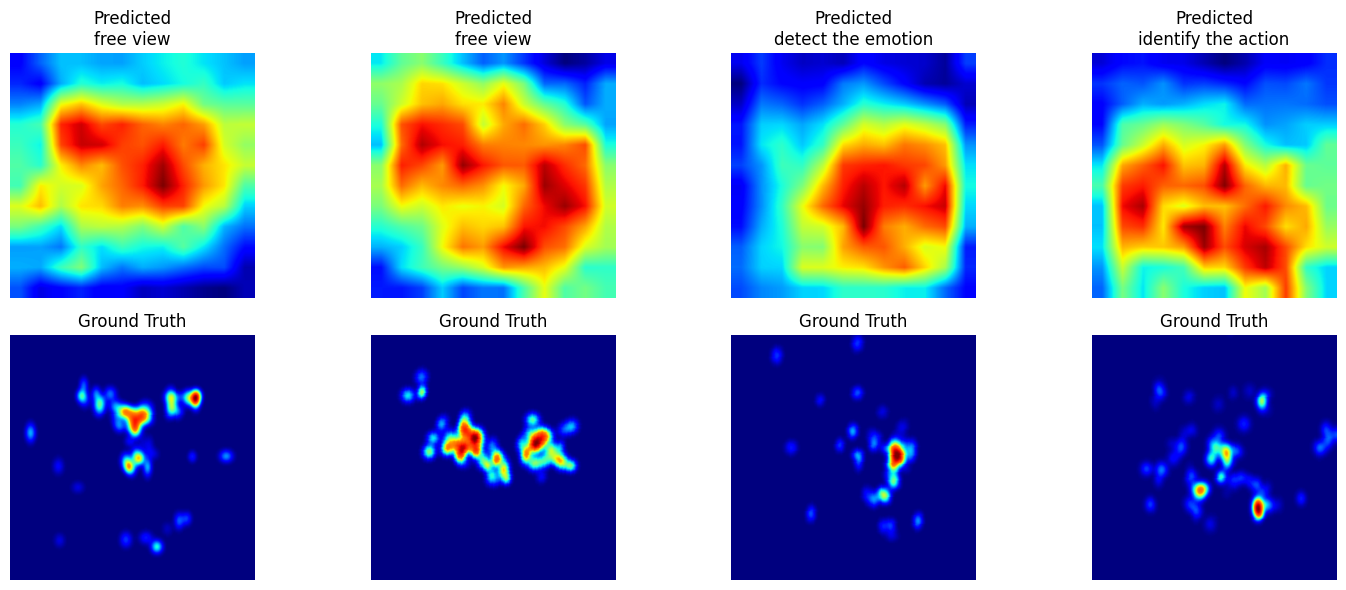

In [10]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    batch_data = next(iter(dataloader))  # just one batch
    images = batch_data["stimuli"].to(device)
    fdm = batch_data["fdm"].to(device)
    task_descs = batch_data["task_description"]

    pred_saliency = model(images, task_descs)

pred_saliency_np = pred_saliency.cpu().numpy()
fdm_np = fdm.cpu().numpy()

num_samples = pred_saliency_np.shape[0]
fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
for i in range(num_samples):
    axes[0, i].imshow(pred_saliency_np[i, 0], cmap='jet')
    axes[0, i].set_title(f"Predicted\n{task_descs[i]}")
    axes[0, i].axis('off')

    axes[1, i].imshow(fdm_np[i, 0], cmap='jet')
    axes[1, i].set_title("Ground Truth")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()